# Capacity and dispatch optimization of a micro grid - Solution

Task: Optimize the capacities and the dispatch of a micro grid that can be described with the timeseries file "2_timeseries.csv" and below design. 

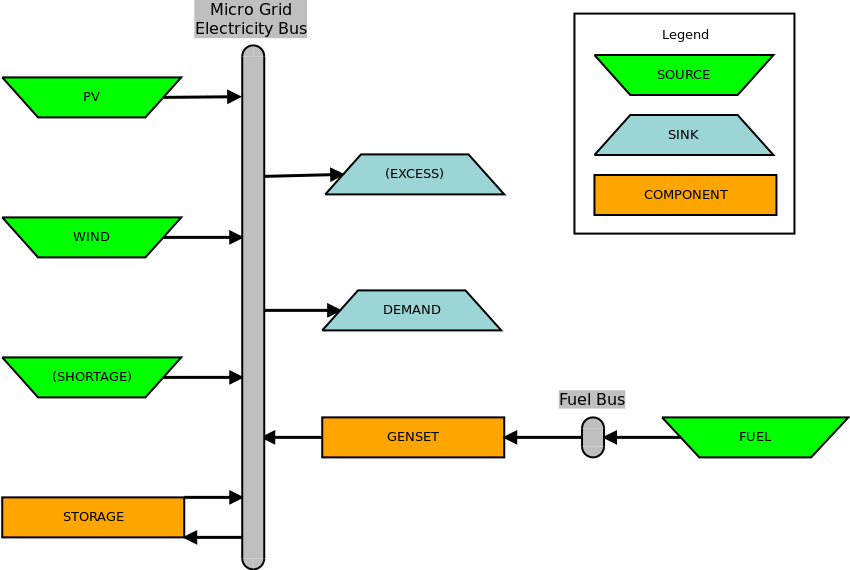

Import all necessary packages (here: including logging)

In [1]:
import os
import pandas as pd

from oemof.tools import logger
import logging

logger.define_logging(screen_level=logging.INFO) #screen_level=logging.DEBUG

from matplotlib import pyplot as plt

import oemof.outputlib as outputlib
import oemof.solph as solph
from oemof.tools import economics

00:31:55-INFO-Path for logging: /home/mh/.oemof/log_files/oemof.log
00:31:55-INFO-Used oemof version: 0.3.1


Initialize your energy system:

In [2]:
duration_hours = 24*1
cost_ratio_timeinterval = duration_hours/(365*24)
timeindex = pd.date_range('1/1/2017', periods=duration_hours, freq='H')

energysystem = solph.EnergySystem(timeindex=timeindex)

Read data and process economic values:

In [3]:
logging.info('Loading timeseries')
full_filename = '1_timeseries.csv'
timeseries = pd.read_csv(full_filename, sep=',')

logging.info('Defining costs')

fuel_price_kWh = 0.6/9.41 # fuel price in currency/kWh

costs = {'wind': {
             'epc': economics.annuity(capex=2000, n=20, wacc=0.05)*cost_ratio_timeinterval},
         'pv': {
             'epc': economics.annuity(capex=750, n=20, wacc=0.05)*cost_ratio_timeinterval},
         'genset': {
             'epc': economics.annuity(capex=300, n=10, wacc=0.05)*cost_ratio_timeinterval,
             'var': 0},
         'storage': {
             'epc': economics.annuity(capex=300, n=5, wacc=0.05)*cost_ratio_timeinterval,
             'var': 0}}

00:31:57-INFO-Loading timeseries
00:31:57-INFO-Defining costs


Create oemof model:

In [4]:
print('\n')
logging.info('DEFINITION OF OEMOF MODEL:')

logging.info('Electricity bus')
bel = solph.Bus(label='electricity_bus')
energysystem.add(bel)

logging.info('Demand, fixed timeseries')
demand_sink = solph.Sink(label='demand',
                         inputs={bel: solph.Flow(actual_value=timeseries['demand_el'],
                                                 fixed=True,
                                                 nominal_value=500)})
energysystem.add(demand_sink)

logging.info('Excess sink')
excess_sink = solph.Sink(label='excess',
                    inputs={bel: solph.Flow()})
energysystem.add(excess_sink)

logging.info('Wind plant with fixed feed-in timeseries')
wind_plant = solph.Source(label='wind',
                          outputs={
                              bel: solph.Flow(nominal_value=None,
                                              fixed=True,
                                              actual_value=timeseries['wind'],
                                              investment=solph.Investment(
                                                  ep_costs=costs['wind']['epc']))})
energysystem.add(wind_plant)

logging.info('PV plant with fixed feed-in timeseries')
pv_plant = solph.Source(label='pv',
                        outputs={
                            bel: solph.Flow(nominal_value=None,
                                            fixed=True,
                                            actual_value=timeseries['pv'],
                                            investment=solph.Investment(
                                                ep_costs=costs['pv']['epc']))})

energysystem.add(pv_plant)

logging.info('Diesel fuel bus, source and transformer')
bfuel = solph.Bus(label='fuel_bus')

fuel_source = solph.Source(label='diesel',
       outputs={
           bfuel: solph.Flow(nominal_value=None,
                     variable_costs=fuel_price_kWh,
                     )}
       )

genset = solph.Transformer(label="genset",
                           inputs={bfuel: solph.Flow()},
                           outputs={bel: solph.Flow(
                               variable_costs=costs['genset']['var'],
                               investment=solph.Investment(
                                   ep_costs=costs['genset']['epc']))},
                           conversion_factors={bel: 0.33}
                           )
energysystem.add(bfuel, fuel_source, genset)

logging.info('Battery storage')
storage = solph.components.GenericStorage(
    label='storage',
    inputs={
        bel: solph.Flow()},
    outputs={
        bel: solph.Flow()},
    loss_rate=0.00,
    initial_storage_level=0.5, # or None
    invest_relation_input_capacity=1/5,
    invest_relation_output_capacity=1,
    inflow_conversion_factor=0.95,
    outflow_conversion_factor=0.95,
    investment=solph.Investment(ep_costs=costs['storage']['epc']))

energysystem.add(storage)



00:31:57-INFO-DEFINITION OF OEMOF MODEL:
00:31:57-INFO-Electricity bus
00:31:57-INFO-Demand, fixed timeseries
00:31:57-INFO-Excess sink
00:31:57-INFO-Wind plant with fixed feed-in timeseries
00:31:57-INFO-PV plant with fixed feed-in timeseries
00:31:57-INFO-Diesel fuel bus, source and transformer
00:31:57-INFO-Battery storage


Solve model:

In [5]:
print('\n')
logging.info('Initializing model')
m = solph.Model(energysystem)

# m.write(filename, io_options={'symbolic_solver_labels': True})

logging.info('Starting oemof-optimization of capacities')
m.solve(solver='cbc', solve_kwargs={'tee': False})



00:31:57-INFO-Initializing model
00:31:57-INFO-Starting oemof-optimization of capacities
00:31:57-INFO-Optimization successful...


{'Problem': [{'Name': 'unknown', 'Lower bound': 764.0731071, 'Upper bound': 764.0731071, 'Number of objectives': 1, 'Number of constraints': 293, 'Number of variables': 224, 'Number of nonzeros': 28, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 0.0, 'Wallclock time': 0.0, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': None, 'Number of created subproblems': None}, 'Black box': {'Number of iterations': 85}}, 'Error rc': 0, 'Time': 0.013462066650390625}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

Process results - optimal capacities:

In [6]:
logging.info('Processing results')
results = outputlib.processing.results(m)
el_bus = outputlib.views.node(results, 'electricity_bus')

logging.info('Get optimized capacities')
cap_wind = el_bus['scalars'][(('wind', 'electricity_bus'), 'invest')]
cap_pv = el_bus['scalars'][(('pv', 'electricity_bus'), 'invest')]
cap_genset = el_bus['scalars'][(('genset', 'electricity_bus'), 'invest')]


el_storage = outputlib.views.node(results, 'storage')
cap_storage = el_storage['scalars'][(('storage', 'None'), 'invest')] # Divided by c-rate charge

logging.info('Capacities optimized: Storage (' + str(cap_storage)
             + '), Wind (' + str(cap_wind)
             + '), PV (' + str(cap_pv)
             + '), Genset (' + str(cap_genset) + ').')

00:31:57-INFO-Processing results
00:31:57-INFO-Get optimized capacities
00:31:57-INFO-Capacities optimized: Storage (303.44179), Wind (1128.5236), PV (613.21074), Genset (66.607433).


Process results - energy flows:

00:31:57-INFO-Plot flows on electricity bus


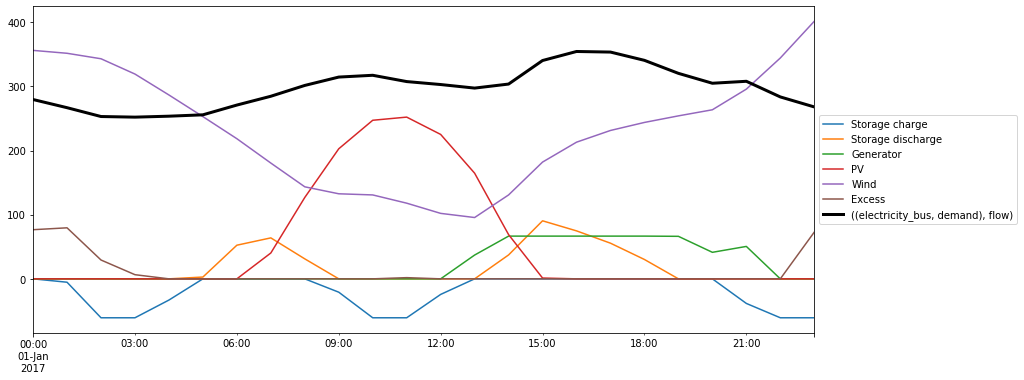

In [7]:
logging.info('Plot flows on electricity bus')
el_sequences = el_bus['sequences']

el_prod = pd.DataFrame(index=timeindex)
el_prod['Storage charge'] = - el_sequences[(('electricity_bus', 'storage'), 'flow')].clip(lower=0)
el_prod['Storage discharge'] = el_sequences[(('storage', 'electricity_bus'), 'flow')].clip(lower=0)
el_prod['Generator']=el_sequences[(('genset', 'electricity_bus'), 'flow')]
el_prod['PV']=el_sequences[(('pv', 'electricity_bus'), 'flow')]
el_prod['Wind']=el_sequences[(('wind', 'electricity_bus'), 'flow')]
el_prod['Excess']=el_sequences[(('electricity_bus', 'excess'), 'flow')]

fig, ax = plt.subplots(figsize=(14, 6))
# line plot
el_prod.plot(ax=ax)
# area plot
#el_prod.plot.area(ax=ax)
el_sequences[(('electricity_bus', 'demand'), 'flow')].plot(ax=ax, linewidth=3, c='k')
legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot